# <p style='text-align: center;'> Back-driving a truck with fuzzy controller</p>

### Importing needed libraries

In [1]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as mt
import pandas as pd

## Step1: Defining Fuzzy Sets 
According to problem situation: <br />
$x(m) \in [0,10]$ <br />
$\varphi(deg) \in [0,90]$ <br />
$\theta(deg) \in [-20,20]$ <br />

In [2]:
# Definition of triangular fuzzy set
class triangularFuzzySet:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

#### Defining Fuzzy Sets for $ x \in Ai$


In [3]:
indexA =["S1", "CE", "B1"]
num = 3

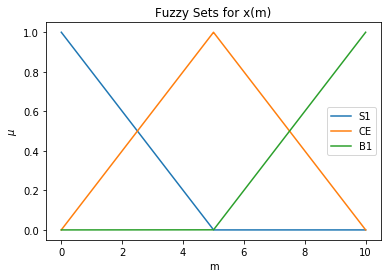

In [4]:
xRange = 10
A = [triangularFuzzySet(a=-xRange/(num-1)+xRange/(num-1)*i,
                        b=0+xRange/(num-1)*i, 
                        c=xRange/(num-1)+xRange/(num-1)*i) for i in range(num)]
x = np.linspace(0,10,10000)
for i in range(num):
    plt.plot(x,fuzz.membership.trimf(x, [A[i].a, A[i].b, A[i].c]), label=indexA[i]) 
plt.xlabel("m")
plt.ylabel("$\mu$")
plt.title("Fuzzy Sets for x(m)")
plt.legend();

#### Defining Fuzzy Sets for $\varphi(deg) \in Bi$

In [5]:
indexB =["S1", "CE", "B1"]
num = 3

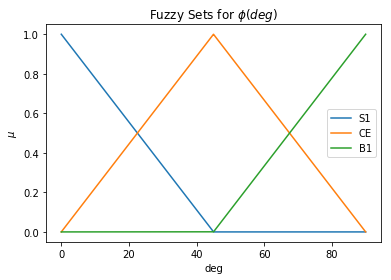

In [6]:
phiRange = 90
B = [triangularFuzzySet(a=-phiRange/(num-1)+phiRange/(num-1)*i,
                        b=phiRange/(num-1)*i,
                        c=phiRange/(num-1)+phiRange/(num-1)*i) for i in range(num)]
x = np.linspace(0,phiRange,9000)
for i in range(num):
    plt.plot(x,fuzz.membership.trimf(x, [B[i].a, B[i].b, B[i].c]), label=indexB[i]) 
plt.xlabel("deg")
plt.ylabel("$\mu$")
plt.title("Fuzzy Sets for $\phi(deg)$")
plt.legend();

#### Defining Fuzzy Sets for $\theta(deg) \in Ci$

In [7]:
indexC =["S1", "CE", "B1","B2"]
num = 3
S1 = 0
CE = 1
B1 = 2
N = 3

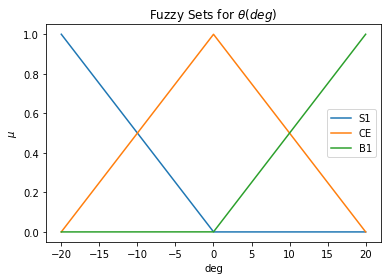

In [8]:
thetaRange = 40
C = [triangularFuzzySet(a=-20-thetaRange/(num-1)+thetaRange/(num-1)*i,
                        b=-20+thetaRange/(num-1)*i, 
                        c=-20+thetaRange/(num-1)+thetaRange/(num-1)*i) for i in range(num)]
d = np.linspace(-20,20,4000)
Ci = np.zeros([num+1,4000])
for i in range(num):
    Ci[i] = fuzz.membership.trimf(d, [C[i].a, C[i].b, C[i].c])
    plt.plot(d,Ci[i], label=indexC[i]) 
plt.xlabel("deg")
plt.ylabel("$\mu$")
plt.title(r'Fuzzy Sets for $\theta(deg)$')
plt.legend();

## Step 2 & 3 : Generating rules from dataset and assinging a degree to each rule

This function compare the known facts with the antecedents of fuzzy rules to find the degrees of compatibility with respect to each antecedent MF.[1]

In [9]:
#Degrees of compatibility
def doc(fuzzy_set, singleton_input):
    if (singleton_input<=fuzzy_set.a):
        return 0
    
    if (singleton_input>fuzzy_set.a and singleton_input<=fuzzy_set.b):
        return (1/(fuzzy_set.b-fuzzy_set.a)*(singleton_input-fuzzy_set.a))
    
    if (singleton_input>fuzzy_set.b and singleton_input<=fuzzy_set.c):
        return (1-1/(fuzzy_set.c-fuzzy_set.b)*(singleton_input-fuzzy_set.b))
    
    if (singleton_input>fuzzy_set.c):
        return 0
    
    print("Error:" + str(singleton_input))

An observation of a truck driver operation

In [10]:
data = np.array([[1,    90,   20 ],
                 [1   , 80.1, 17 ],
                 [1.16, 71.7, 15 ],
                 [1.46, 64.3, 13 ],
                 [1.89, 57.8, 11 ],
                 [2.41, 52.4, 9  ],
                 [3.01, 47.9, 6  ],
                 [3.68, 44.9, 3  ],
                 [4.38, 43.4, 1  ],
                 [5.11, 42.9, -1 ],
                 [5.84, 43.4, -3 ],
                 [6.57, 44.9, -5 ],
                 [7.28, 47.4, -8 ],
                 [7.94, 51.4, -11],
                 [8.56, 56.9, -13],
                 [9.09, 63.3, -15],
                 [9.52, 70.7, -17],
                 [9.84, 79.1, -20]])

dataset = pd.DataFrame(data, index=range(18), columns=[ "x(m)", "phi(deg)", "theta(deg)"])

In [11]:
#Generating rules from dataset
likely_x_set=  [indexA[np.argmax([doc(A[i],data[j,0]) 
                                 for i in range(len(A))])] for j in dataset.index]
likely_phi_set=  [indexB[np.argmax([doc(B[i],data[j,1]) 
                                 for i in range(len(B))])] for j in dataset.index]
likely_theta_set=  [indexC[np.argmax([doc(C[i],data[j,2]) 
                                 for i in range(len(C))])] for j in dataset.index]
#Assinging a degree to each rule
likely_x_set_degree=  np.array([np.max([doc(A[i],data[j,0]) 
                                 for i in range(len(A))]) for j in dataset.index])
likely_phi_set_degree=  np.array([np.max([doc(B[i],data[j,0]) 
                                 for i in range(len(B))]) for j in dataset.index])
likely_theta_set_degree=  np.array([np.max([doc(C[i],data[j,0]) 
                                 for i in range(len(C))]) for j in dataset.index])
degree = likely_x_set_degree*likely_phi_set_degree*likely_theta_set_degree

In [12]:
dataset.join(pd.DataFrame({"likely_x_set":likely_x_set, 
                          "likely_phi_set":likely_phi_set,
                          "likely_theta_set":likely_theta_set,
                          "degree":degree}))

,x(m),phi(deg),theta(deg),likely_x_set,likely_phi_set,likely_theta_set,degree
0,1.00,90.0,20.0,S1,B1,B1,0.743111
1,1.00,80.1,17.0,S1,B1,B1,0.743111
2,1.16,71.7,15.0,S1,B1,B1,0.704807
3,1.46,64.3,13.0,S1,CE,B1,0.635022
4,1.89,57.8,11.0,S1,CE,B1,0.539566
5,2.41,52.4,9.0,S1,CE,CE,0.431182
6,3.01,47.9,6.0,CE,CE,CE,0.477192
7,3.68,44.9,3.0,CE,CE,CE,0.551462
8,4.38,43.4,1.0,CE,CE,CE,0.617565
9,5.11,42.9,-1.0,CE,CE,CE,0.645439


# Step4: Generating Rule base

In [13]:
#N means there is no rule

            #    phi(deg)    
            #S1  CE   B
rule_base = [[B1, B1, B1], # S1
             [CE, CE,  CE], # CE x(m)
             [S1, S1, S1]] # B1

# Step 5: Simulation

1. **Degrees of compatibility**[1]
2. **Firing Strength**: Combine degrees of compatibility with respect to antecedent MFs in a rule using fuzzy **AND (product)** operators to form a firing strength that indicates the degree to which the antecedent part of the rule is satisfied.[1]

3. ***Qualified (induced) consequent MFs***: Apply the firing strength to the consequent MF **(here by product)*** of a rule to generate a qualified consequent MF.[1]
4. ***Overall output MF***: Aggregate all the qualified consequent MFs to obtain an overall output MF.[1]

In [14]:
def fuzzy_controller(x, phi):
    # 1. Degrees of compatibility 
    # 2. Firing Strength: 
    u = np.array([[doc(A[i], x)*doc(B[j], phi) 
                   for j in range(len(B))] 
                  for i in range(len(A))])
    # 3. Qualified (induced) consequent MFs
    thetai = np.array([ [Ci[rule_base[i][j]]*u[i,j] for j in range(len(B))] 
                       for i in range(len(A))])
    # 4. Overall output MF
    theta = thetai [0,0]
    for i in range(len(A)):
        for j in range(len(B)):
            theta = np.maximum(thetai[i,j],theta)
            
    #defuzzification : COA     
    theta  = np.sum(theta*d)/np.sum(theta)
    
    return theta

### Simulation1: $(x_0, \phi_0) = (0,88)$

x_final:10.183024905363192    phi_final:88.24491217596699


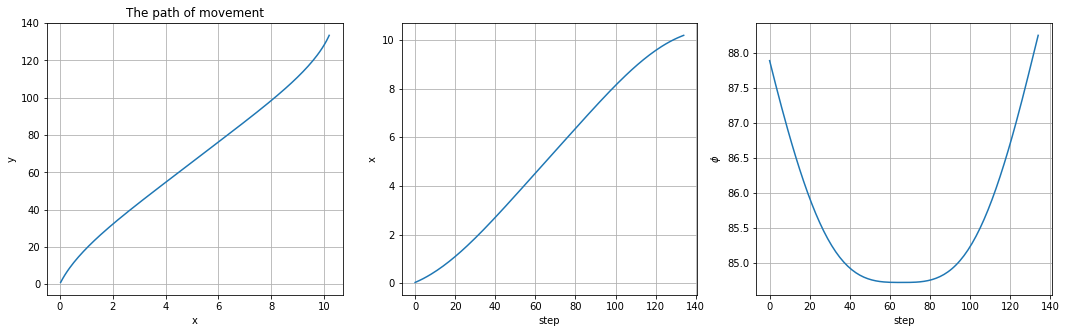

In [15]:
x = 0
x_mem = np.zeros([0])
y = 0
y_mem = np.zeros([0])
phi = 88
phi_mem =np.ndarray([0])
while ( not np.isclose(x,10,0.02) or not np.isclose(phi,90,0.02)):
    theta = fuzzy_controller(x, phi)
    x = x + np.cos((phi+theta)*np.pi/180) + np.sin((theta)*np.pi/180)*np.sin((phi)*np.pi/180)
    y = y + np.sin((phi+theta)*np.pi/180) - np.sin((theta)*np.pi/180)*np.cos((phi)*np.pi/180)
    phi = phi - np.arcsin(2*np.sin(theta*np.pi/180)/4)
    x_mem = np.append(x_mem,x)
    y_mem = np.append(y_mem,y)
    phi_mem = np.append(phi_mem,phi)
    
print("x_final:"+str(x) +"    phi_final:"+str(phi) )
    
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.plot(x_mem,y_mem)
plt.xlabel('x')
plt.ylabel('y')
plt.title("The path of movement")
plt.grid();
plt.subplot(132)
plt.plot(x_mem)
plt.xlabel("step")
plt.ylabel("x")
plt.grid();
plt.subplot(133)
plt.plot(phi_mem)
plt.xlabel("step")
plt.ylabel("$\phi$")
plt.grid();

### Simulation2 : $(x_0, \phi_0) = (2,94)$

x_final:9.926300763442171    phi_final:89.15341678929418


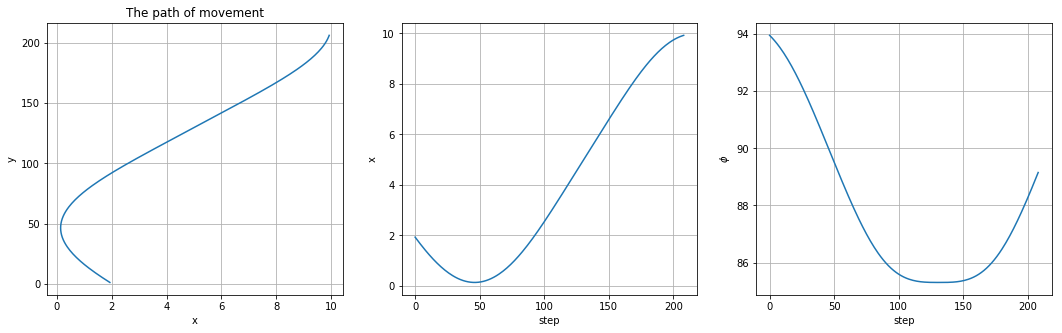

In [16]:
x = 2
x_mem = np.zeros([0])
y = 0
y_mem = np.zeros([0])
phi = 94
phi_mem =np.ndarray([0])
while ( not np.isclose(x,10,0.01) or not np.isclose(phi,90,0.01)):
    theta = fuzzy_controller(x, phi)
    x = x + np.cos((phi+theta)*np.pi/180) + np.sin((theta)*np.pi/180)*np.sin((phi)*np.pi/180)
    y = y + np.sin((phi+theta)*np.pi/180) - np.sin((theta)*np.pi/180)*np.cos((phi)*np.pi/180)
    phi = phi - np.arcsin(2*np.sin(theta*np.pi/180)/4)
    x_mem = np.append(x_mem,x)
    y_mem = np.append(y_mem,y)
    phi_mem = np.append(phi_mem,phi)

print("x_final:"+str(x) +"    phi_final:"+str(phi) )

plt.figure(figsize=(18,5))

plt.subplot(131)
plt.plot(x_mem,y_mem)
plt.xlabel('x')
plt.ylabel('y')
plt.title("The path of movement")
plt.grid();
plt.subplot(132)
plt.plot(x_mem)
plt.xlabel("step")
plt.ylabel("x")
plt.grid();
plt.subplot(133)
plt.plot(phi_mem)
plt.xlabel("step")
plt.ylabel("$\phi$")
plt.grid();

[1] Type-2 Fuzzy Logic: Theory and Applications ,Publisher: Springer Berlin Heidelbergm